Based on the examples from:
https://www.tensorflow.org/lite/performance/post_training_integer_quant

In [1]:
import numpy as np
import tensorflow as tf

import keras
from keras.datasets import mnist
from keras.utils import np_utils



In [2]:
# Load the datasets for training and test
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


In [3]:
# Prepare the input data
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [4]:
# num_classes = 10
# convert class vectors to binary class matrices
# train_labels = keras.utils.np_utils.to_categorical(train_labels, num_classes)
# ktest_labels = keras.utils.np_utils.to_categorical(test_labels, num_classes)

In [5]:
from keras.models import Sequential
from keras import models, layers
from keras import regularizers


In [6]:
# Create the model
from keras.models import Sequential
from keras import models, layers
from keras import regularizers

# Define the model architecture
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 12)        120       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 12)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2028)              0         
                                                                 
 dense (Dense)               (None, 10)                20290     
                                                                 
Total params: 20,410
Trainable params: 20,410
Non-trainable params: 0
____________________________________________________

In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])

In [8]:
hist = model.fit(train_images, train_labels,
                        epochs=5,
                        verbose=1,
                        validation_data=(test_images,test_labels))

Epoch 1/5
  22/1875 [..............................] - ETA: 4s - loss: 2.0507 - accuracy: 0.4034  

2022-09-24 17:34:55.210315: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1875/1875 [==============================] - 5s 3ms/step - loss: 0.2730 - accuracy: 0.9241 - val_loss: 0.1252 - val_accuracy: 0.9632
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1117 - accuracy: 0.9679 - val_loss: 0.0977 - val_accuracy: 0.9702
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0840 - accuracy: 0.9749 - val_loss: 0.0756 - val_accuracy: 0.9764
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0701 - accuracy: 0.9797 - val_loss: 0.0795 - val_accuracy: 0.9754
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0608 - accuracy: 0.9821 - val_loss: 0.0645 - val_accuracy: 0.9792


In [9]:
# Calibration data 
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]


In [10]:
# non quantized model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/y7/lgb6jsgs7y5_xp5pqnhc09k80000gn/T/tmp4gufw3pz/assets


2022-09-24 17:35:21.810286: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-09-24 17:35:22.090524: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-09-24 17:35:22.090543: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-09-24 17:35:22.090680: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/y7/lgb6jsgs7y5_xp5pqnhc09k80000gn/T/tmp4gufw3pz
2022-09-24 17:35:22.091422: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-09-24 17:35:22.091428: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /var/folders/y7/lgb6jsgs7y5_xp5pqnhc09k80000gn/T/tmp4gufw3pz
2022-09-24 17:35:22.094088: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-09-24 17:35:

In [11]:
# Quantize the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()



INFO:tensorflow:Assets written to: /var/folders/y7/lgb6jsgs7y5_xp5pqnhc09k80000gn/T/tmp_3bo8af6/assets


INFO:tensorflow:Assets written to: /var/folders/y7/lgb6jsgs7y5_xp5pqnhc09k80000gn/T/tmp_3bo8af6/assets
/Users/mawad/miniconda3/envs/jupyter/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-09-24 17:35:22.561108: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-09-24 17:35:22.561123: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-09-24 17:35:22.561211: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/y7/lgb6jsgs7y5_xp5pqnhc09k80000gn/T/tmp_3bo8af6
2022-09-24 17:35:22.561903: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-09-24 17:35:22.561909: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug in

In [12]:
# Helper function to run inference on a TFLite model
def run_tflite_model(model, test_image_indices):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_content=model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]
    test_label = test_labels[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions

In [13]:
import matplotlib.pylab as plt

# Change this to test a different image
test_image_index = 1

## Helper function to test the models on one image
def test_model(tflite_model, test_image_index, model_type):
  global test_labels

  predictions = run_tflite_model(tflite_model, [test_image_index])

  plt.imshow(test_images[test_image_index])
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(test_labels[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)

INFO: Initialized TensorFlow Lite runtime.


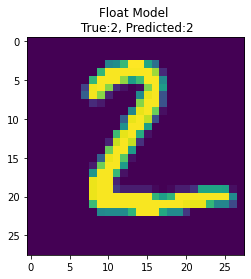

In [14]:
test_model(tflite_model_quant, test_image_index, model_type="Float")


INFO: Applying 1 TensorFlow Lite delegate(s) lazily.


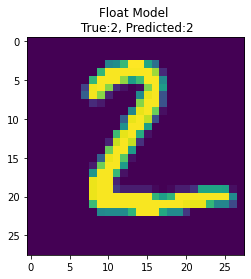

In [15]:
test_model(tflite_model, test_image_index, model_type="Float")


In [16]:
def evaluate_model(tflite_model, model_type):
  global test_images
  global test_labels

  test_image_indices = range(test_images.shape[0])
  predictions = run_tflite_model(tflite_model, test_image_indices)

  accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))

In [17]:
evaluate_model(tflite_model, model_type="Float")


INFO: Applying 1 TensorFlow Lite delegate(s) lazily.


Float model accuracy is 97.9200% (Number of test samples=10000)


In [18]:
evaluate_model(tflite_model_quant, model_type="Quantized")


Quantized model accuracy is 97.8700% (Number of test samples=10000)
